# Region comparison
This notebook compares the accuracy of the predictions between the different regions. Thus, it is checked whether the algorithms in the current specification can be applied to the data relating to Great Britain and the USA in addition to the data relating to Germany.

## Preparation
- Imports
- Declare classifiers

In [1]:
from pandas import DataFrame
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from datetime import datetime
from datetime import timedelta

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7)

classifiers = []

classifiers.append(['Decision Tree', DecisionTreeClassifier()])
classifiers.append(['K Nearest Neighbor', KNeighborsClassifier(n_jobs=-1)])
classifiers.append(['Random Forest', RandomForestClassifier(n_jobs=-1)])
classifiers.append(['XG Boost', XGBClassifier(use_label_encoder=False, verbosity=0)])
classifiers.append(['SVM', SVC(kernel='rbf', random_state = 1)])

classifiers.append(['Decision Tree (optimized)', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None, max_features=None, max_leaf_nodes=50, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=2, min_weight_fraction_leaf=0.0, splitter='best')])
classifiers.append(['K Nearest Neighbor (optimized)', KNeighborsClassifier(n_jobs=-1, algorithm='kd_tree', leaf_size=20, n_neighbors=8, p=1, weights='uniform')])
classifiers.append(['Random Forest (optimized)', RandomForestClassifier(n_jobs=-1, class_weight=None, criterion='gini', max_depth=9, max_features='log2', max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=1, min_samples_split=4, min_weight_fraction_leaf=0.0, n_estimators=200)])
classifiers.append(['XG Boost (optimized)', XGBClassifier(use_label_encoder=False, verbosity=0, booster='gbtree', colsample_bylevel=0.75, colsample_bynode=1, colsample_bytree=1, gamma=2, learning_rate=0.5, max_delta_step=0, max_depth=6, min_child_weight=1, n_estimators=100, reg_alpha=1, reg_lambda=0, subsample=1, tree_method='hist')])

classifiers.append(['K Nearest Neighbor (maxed)', KNeighborsClassifier(n_jobs=-1, n_neighbors=300)])

## Iterate over regions
In the next step, the program iterates over the available regions, reads in the respective data, prepares them and then applies the various prediction algorithms. The latter happens five times per region with different splitting of the data into training and test data in order to show the reproducibility of the results.

In [2]:
%%time
regions = ['DE', 'GB', 'US']
results = pd.DataFrame(columns=['region', 'algorithm', 'accuracy', 'execution_time'])

for region in regions:
    # Data preperation
    df = pd.read_csv('../0_data/' + region + 'videos.csv',
    low_memory=False)

    df['trending_date'] = df.apply(lambda row: datetime.strptime(row['trending_date'], '%y.%d.%m'), axis=1)
    df['publish_time'] = df.apply(lambda row: datetime.strptime(row['publish_time'], '%Y-%m-%dT%H:%M:%S.000Z'), axis=1)
    df['days_until_trending'] = df.apply(lambda row: ((row['trending_date'] - row['publish_time']).days + 1), axis=1)

    df['tags_count'] = df.apply(lambda row: len(row['tags'].split('|')), axis=1)
    df['publish_hour'] = df['publish_time'].map(lambda x: x.hour)
    df['publish_month'] = df['publish_time'].map(lambda x: x.month)
    df['publish_year'] = df['publish_time'].map(lambda x: x.year)
    df['publish_day_of_month'] = df['publish_time'].map(lambda x: x.day)
    df['publish_weekday'] = df['publish_time'].map(lambda x: x.weekday()) # 0: Monday, 6: Sunday

    df['like_dislike_ratio'] = df.apply(lambda row: row['likes'] / (row['dislikes'] + 1), axis=1)
    df['like_view_ratio'] = df.apply(lambda row: row['likes'] / (row['views'] + 1), axis=1)

    df['ratings'] = df['likes'] + df['dislikes']
    df['likes_per_rating'] = df.apply(lambda row: 0 if row['ratings'] == 0 else row['likes'] / row['ratings'], axis=1)
    df['ratings_per_view'] = df['ratings'] / df['views']
    df['comments_per_view'] = df['comment_count'] / df['views']

    def assign_target_category(row):
        if row['days_until_trending'] == 0: 
            return 0
        elif row['days_until_trending'] == 1:
            return 1
        elif row['days_until_trending'] == 2:
            return 2
        elif row['days_until_trending'] <= 5:
            return 3
        else:
            return 6

    df['target_category'] = df.apply(assign_target_category, axis=1)
    df['channel_title'] = df['channel_title'].astype('category')

    tag_df = pd.read_csv('../0_data/' + region + 'tags.csv')
    tag_df = tag_df.set_index('tag')
    def calculate_tag_factor(tag_string, tag_data):
        tag_list = pd.Series(list(set(map(lambda x: x.strip('\"').lower(), tag_string.split('|')))))
        return tag_list.apply(lambda tag: tag_data['factor'].get(tag, np.nan)).mean(skipna=True)
        
    df['tag_factors'] = df['tags'].apply(lambda x: calculate_tag_factor(x, tag_df))
    df['tag_factors'] = df.apply(lambda row: 0 if np.isnan(row['tag_factors']) else row['tag_factors'], axis=1)

    N = len(df)
    dropColumns = ['video_id', 'title', 'tags', 'thumbnail_link', 'description']
    for column in df.columns:
        numberOfUniqueValues = df[column].nunique()
        if numberOfUniqueValues < 2:
            dropColumns.append(column)
        elif df[column].dtype == 'object' and numberOfUniqueValues > N * 0.9:
            dropColumns.append(column)
        elif df[column].isna().sum() / N > 0.95:
            dropColumns.append(column)
            
    df.drop(columns=dropColumns, inplace=True)

    # Encode features
    x_df = DataFrame(index=df.index)
    features = ['views', 'publish_hour', 'ratings_per_view', 'comments_per_view', 'tag_factors']
    for feature in features:
        feature_data = df[feature]
        if df[feature].dtype.name == 'category':
            x_label_encoder = preprocessing.LabelEncoder()
            x_label_encoder.fit(feature_data.astype(str))
            x_df[feature] = x_label_encoder.transform(feature_data)
        elif df[feature].dtype.name == 'datetime64[ns]':
            x_df[feature] = feature_data.to_seconds()
        elif df[feature].dtype.name == 'bool':
            x_df[feature] = int(feature_data)
        else:
            x_df[feature] = feature_data

    x = np.reshape(x_df, (-1, len(x_df.columns)))

    # Encode target
    target = df['target_category'].astype(str)
    y_label_encoder = preprocessing.LabelEncoder()
    y_label_encoder.fit(target)
    y = y_label_encoder.transform(target)

    # Test with multiple train-test splits
    for i in range(5):

        # Create data subsets
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.40, random_state=i)

        # Train model and predict test data
        for classifier in classifiers:
            start_time = time.time()
            classifier[1].fit(x_train, y_train)
            y_pred = classifier[1].predict(x_test)
            execution_time = time.time() - start_time
            result = {'region': region, 'algorithm': classifier[0], 'accuracy': accuracy_score(y_test, y_pred), 'execution_time': execution_time}
            results = results.append(result, ignore_index=True)

Wall time: 20min 35s


## Results
In the following the accuracy and the time required of the algorithms for the different regions are compared.

In [3]:
results.head(15)

,region,algorithm,accuracy,execution_time
0,DE,Decision Tree,0.599596,0.246031
1,DE,K Nearest Neighbor,0.589006,0.600974
2,DE,Random Forest,0.682786,1.419570
3,DE,XG Boost,0.676543,9.740281
4,DE,SVM,0.634182,70.922860
5,DE,Decision Tree (optimized),0.657505,0.101182
6,DE,K Nearest Neighbor (optimized),0.601310,0.681313
7,DE,Random Forest (optimized),0.678379,1.653162
8,DE,XG Boost (optimized),0.678318,1.574599
9,DE,K Nearest Neighbor (maxed),0.634794,1.149529


### Accuracy
It is noticeable that the accuracy for the UK-related data is comparatively high, but rather low for the USA. This is directly related to the [distribution of the data](https://github.com/StephanHagge/data-mining/blob/master/5_evaluation/regions_data_distribution.ipynb) in relation to the target categories.

<AxesSubplot:xlabel='region', ylabel='accuracy'>

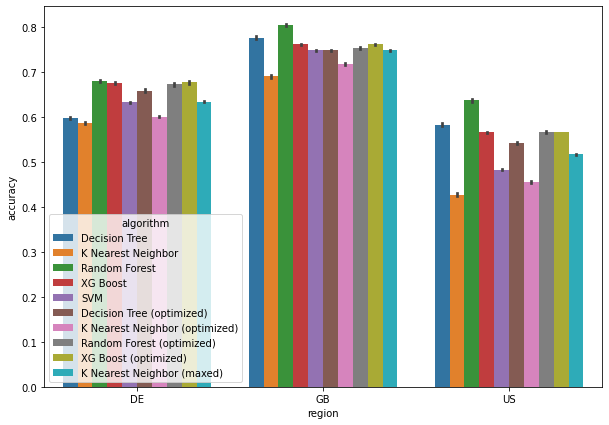

In [7]:
sns.barplot(data=results, x='region', y='accuracy', hue='algorithm')

#### Execution time
No particular abnormalities can be observed at this point. The execution time remains constant and is slightly shorter for Great Britain.

<AxesSubplot:xlabel='region', ylabel='execution_time'>

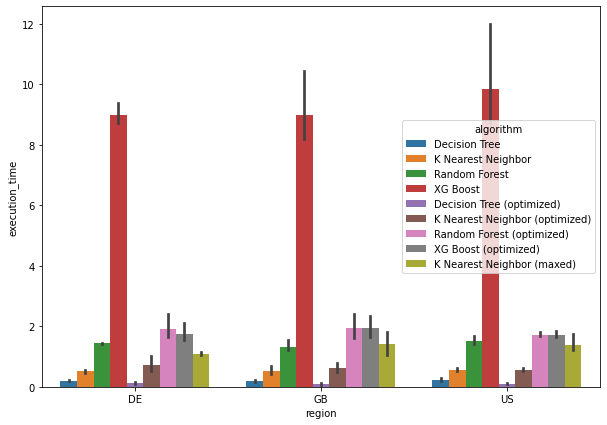

In [8]:
sns.barplot(data=results[results['algorithm'].str.contains('SVM') == False], x='region', y='execution_time', hue='algorithm')

Differences in the execution time only become visible when looking at the SVM. It should be noted that the UK-related dataset is smaller and more focused on one of the target categories.

<AxesSubplot:xlabel='region', ylabel='execution_time'>

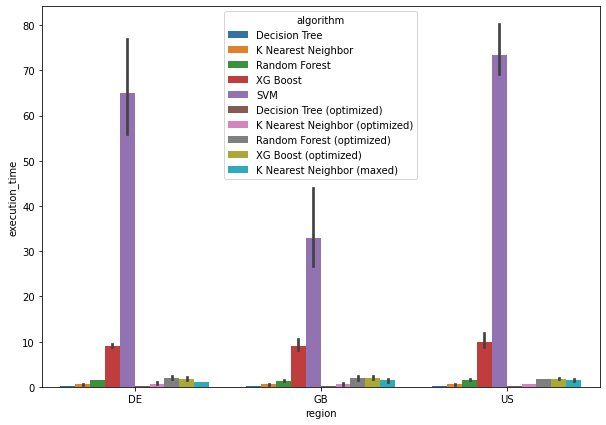

In [9]:
sns.barplot(data=results, x='region', y='execution_time', hue='algorithm')